# Benchmarking

Notebook to organise benchmarks of different implementations of the density-criterion (similarity) check. In general, two neighbourhood containers are tested to have at least a certain number of common elements. For an even base line, only cythonised versions are tested. The possible variants use:

  - Python set intersection
  - Python set controlled queries
  - libcpp.set controlled queries
  - NumPy array intersection
  - NumPy array controlled queries

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pre-requirements" data-toc-modified-id="Pre-requirements-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pre-requirements</a></span></li><li><span><a href="#Version-info" data-toc-modified-id="Version-info-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Version info</a></span></li><li><span><a href="#Helper-function-definitions" data-toc-modified-id="Helper-function-definitions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Helper function definitions</a></span></li><li><span><a href="#Python-set" data-toc-modified-id="Python-set-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Python set</a></span></li><li><span><a href="#NumPy-Array" data-toc-modified-id="NumPy-Array-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>NumPy Array</a></span></li></ul></div>

## Pre-requirements

In [2]:
from collections import defaultdict
import sys
import time

import numpy as np

# %matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt

# Jupyter extensions
%load_ext Cython
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
# Matplotlib configuration
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rc_file("../matplotlibrc", use_default_template=False)

In [4]:
%%HTML
<style>
.container { width:85% !important; }
</style>

## Version info

In [59]:
print(f"{'Python':>20} :  ", *sys.version.splitlines())

modules = [
]

for alias, m in modules:
    try:
        print(f"{alias:>20} :  ", m.__version__)
    except AttributeError:
        print(f"{alias:>20} :  ", "no version info")

              Python :   3.8.5 | packaged by conda-forge | (default, Aug 21 2020, 18:21:27)  [GCC 7.5.0]


## Helper function definitions

In [6]:
CASES_HIGH_SIM = [ # a, b, c
    (range(10), range(10), "10"),
    (range(100), range(100), "100"),
    (range(1000), range(1000), "1000"),
    (range(10000), range(10000), "10000"),
    (range(100000), range(100000), "100000"),
    (range(1000000), range(1000000), "1000000"),
]

CASES_LOW_SIM = [ # a, b, c
    (range(10), range(10, 20), "10"),
    (range(100), range(100, 200), "100"),
    (range(1000), range(1000, 2000), "1000"),
    (range(10000), range(10000, 20000), "10000"),
    (range(100000), range(100000, 200000), "100000"),
    (range(1000000), range(1000000, 2000000), "1000000"),
]

In [7]:
def format_case(case, form="set"):
    if form == "set":
        return tuple(set(x) for x in case[:2]) + (case[2], )
    elif form == "array":
        return tuple(np.asarray(x, dtype=np.intp) for x in case[:2]) + (case[2], )
    else:
        raise ValueError("Unknown format")

## Python set

In [8]:
%%cython

cpdef bint check_similarity_set(set a, set b, Py_ssize_t c):
    """Check if similarity criterion is fulfilled.

    Args:
        a: Set of point indices
        b: Set (collection) of point indices
        c: Similarity cut-off

    Returns:
        True if set `a` and set `b` have at least `c` common
        elements
    """

    if c == 0:
        return 1
    
    cdef Py_ssize_t len_intersec = len(a.intersection(b))
    if len_intersec >= c:
        return 1
    return 0

In [9]:
%%cython

cpdef bint check_similarity_set_min(set a, set b, Py_ssize_t c):
    """Check if similarity criterion is fulfilled.

    Args:
        a: Set of point indices
        b: Set (collection) of point indices
        c: Similarity cut-off

    Returns:
        True if set `a` and set `b` have at least `c` common
        elements
    """

    if c == 0:
        return 1
    
    if len(a) > len(b):
        a, b = b, a
    
    cdef Py_ssize_t ai
    cdef Py_ssize_t common = 0

    for ai in a:
        if ai in b:
            common += 1
            if common == c:
                return 1

    return 0

## NumPy Array

In [10]:
%%cython -a

import numpy as np
cimport numpy as np

ctypedef np.intp_t ARRAYINDEX_DTYPE_t

cpdef bint check_similarity_array_min(
        ARRAYINDEX_DTYPE_t[::1] a,
        ARRAYINDEX_DTYPE_t[::1] b,
        ARRAYINDEX_DTYPE_t c):
    """Check if the CNN criterion is fullfilled

    Check if `a` and `b` have at least `c` common elements.  Faster than
    computing the intersection (say with `numpy.intersect1d`) and
    comparing its length to `c`.

    Args:
        a, b: 1D Array of integers (neighbour point indices) that
            supports the buffer protocol.
        c: Check if `a` and `b` share this many elements.
    Returns:
        1 if set `a` and set `b` have at least `c` common
        elements, 0 otherwise
    """

    cdef ARRAYINDEX_DTYPE_t i, j                   # Control variables
    cdef ARRAYINDEX_DTYPE_t sa = a.shape[0]        # Array lengths
    cdef ARRAYINDEX_DTYPE_t sb = b.shape[0]
    cdef ARRAYINDEX_DTYPE_t ai, bj                 # Checked elements
    cdef ARRAYINDEX_DTYPE_t common = 0             # Common neighbours count

    if c == 0:
        return 1
    
    if sa > sb:
        a, b = b, a

    for i in range(sa):
        ai = a[i]
        for j in range(sb):
            bj = b[j]
            if ai == bj:
                # Check similarity and return/move on early
                common += 1
                if common == c:
                    return 1
                break
    return 0

In [11]:
%%cython

import numpy as np
cimport numpy as np

ctypedef np.intp_t ARRAYINDEX_DTYPE_t

cpdef bint check_similarity_array(
        ARRAYINDEX_DTYPE_t[::1] a,
        ARRAYINDEX_DTYPE_t[::1] b,
        ARRAYINDEX_DTYPE_t c):
    """Check if the CNN criterion is fullfilled

    Check if `a` and `b` have at least `c` common elements.

    Args:
        a, b: 1D Array of integers (neighbour point indices) that
            supports the buffer protocol.
        c: Check if `a` and `b` share this many elements.
    Returns:
        1 if set `a` and set `b` have at least `c` common
        elements, 0 otherwise
    """

    cdef ARRAYINDEX_DTYPE_t i, j                   # Control variables
    cdef ARRAYINDEX_DTYPE_t ai, bj                 # Checked elements
    cdef ARRAYINDEX_DTYPE_t common                 # Common neighbours count

    if c == 0:
        return 1
    
    common = np.intersect1d(a, b, assume_unique=True).shape[0]
    if common >= c:
        return 1
    return 0

In [38]:
%%cython

from libc.stdlib cimport malloc, free
import numpy as np
cimport numpy as np

ctypedef np.intp_t ARRAYINDEX_DTYPE_t

cpdef bint check_similarity_array_custom(
        ARRAYINDEX_DTYPE_t[::1] a,
        ARRAYINDEX_DTYPE_t[::1] b,
        ARRAYINDEX_DTYPE_t c):
    """Check if the CNN criterion is fullfilled

    Check if `a` and `b` have at least `c` common elements.

    Args:
        a, b: 1D Array of integers (neighbour point indices) that
            supports the buffer protocol.
        c: Check if `a` and `b` share this many elements.
    Returns:
        1 if set `a` and set `b` have at least `c` common
        elements, 0 otherwise
    """
    
    if c == 0:
        return 1

    cdef ARRAYINDEX_DTYPE_t i = 0, j = 0, k = 0  # Control variables
    cdef ARRAYINDEX_DTYPE_t sa = a.shape[0]
    cdef ARRAYINDEX_DTYPE_t sb = b.shape[0]
    cdef ARRAYINDEX_DTYPE_t ai, bj 
    cdef ARRAYINDEX_DTYPE_t common = 0         # Common neighbours count
    
    cdef ARRAYINDEX_DTYPE_t* mergedsort_arrayptr

    mergedsort_arrayptr = <ARRAYINDEX_DTYPE_t*> malloc(sizeof(ARRAYINDEX_DTYPE_t) * (sa + sb))

    ai = a[i]
    bj = b[j]
    while True:
        if ai < bj:
            mergedsort_arrayptr[k] = ai
            i += 1
            k += 1
            if (i == sa):
                mergedsort_arrayptr[k] = b[j]
                j += 1
                k += 1 
                while j < sb:
                    mergedsort_arrayptr[k] = b[j]
                    j += 1
                    k += 1
                break
            ai = a[i]
        else:
            mergedsort_arrayptr[k] = bj
            j += 1
            k += 1
            if (j == sb):
                mergedsort_arrayptr[k] = a[i]
                i += 1
                k += 1 
                while i < sa:
                    mergedsort_arrayptr[k] = a[i]
                    i += 1
                    k += 1
                break
            bj = b[j]
        
    for i in range(k - 1):
        if mergedsort_arrayptr[i] == mergedsort_arrayptr[i + 1]:
            common += 1
            if common == c:
                free(mergedsort_arrayptr)
                return 1
            
    free(mergedsort_arrayptr)
    return 0

In [52]:
%%cython

from libc.stdlib cimport malloc, free
import numpy as np
cimport numpy as np

ctypedef np.intp_t ARRAYINDEX_DTYPE_t

cpdef bint check_similarity_array_custom2(
        ARRAYINDEX_DTYPE_t[::1] a,
        ARRAYINDEX_DTYPE_t[::1] b,
        ARRAYINDEX_DTYPE_t c) nogil:
    """Check if the CNN criterion is fullfilled

    Check if `a` and `b` have at least `c` common elements.

    Args:
        a, b: 1D Array of integers (neighbour point indices) that
            supports the buffer protocol.
        c: Check if `a` and `b` share this many elements.
    Returns:
        1 if set `a` and set `b` have at least `c` common
        elements, 0 otherwise
    """

    cdef ARRAYINDEX_DTYPE_t i = 0, j = 0  # Control variables
    cdef ARRAYINDEX_DTYPE_t sa = a.shape[0]
    cdef ARRAYINDEX_DTYPE_t sb = b.shape[0]
    cdef ARRAYINDEX_DTYPE_t ai, bj, k 
    cdef ARRAYINDEX_DTYPE_t common = 0         # Common neighbours count
    
    ai = a[i]
    bj = b[j]
    k = -1
    while True:
        if ai < bj:
            if ai == k:
                common += 1
                if common == c:
                    return 1
            k = ai
            i += 1
            if (i == sa):
                if bj == k:
                    common += 1
                    if common == c:
                        return 1
                return 0
            ai = a[i] 
        else:
            if bj == k:
                common += 1
                if common == c:
                    return 1
            k = bj
            j += 1
            if (j == sb):
                if ai == k:
                    common += 1
                    if common == c:
                        return 1
                return 0
            bj = b[j]

In [58]:
check_similarity_array_custom2(np.arange(10000), np.arange(10000), 10001)

False

In [37]:
check_similarity_array_custom2(np.array([1, 3, 6, 7]), np.array([1, 2, 3, 6, 7]), 1)

True

In [42]:
check_functions = [
    # (check_similarity_set, "set", "set"),
    # (check_similarity_set_min, "set_min", "set"),
    (check_similarity_array, "array", "array"),
    # (check_similarity_array_min, "array_min", "array"),
    # (check_similarity_array_custom, "array_custom", "array"),
    (check_similarity_array_custom2, "array_custom2", "array"),
    ]

In [43]:
if "timings_high_sim" not in dir():
    timings_high_sim = defaultdict(lambda: defaultdict(dict))
for f, name, form in check_functions:
    for case in CASES_HIGH_SIM:
        case = format_case(case, form=form)
        for c, kind in [(1, "1"), (int(case[2]) // 2, "half"), (int(case[2]), "full")]:
            timings_high_sim[name][case[2]][kind] = %timeit -o f(*case[:2], c)

17.5 µs ± 2.22 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
18.4 µs ± 1.94 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
16.1 µs ± 763 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
20.5 µs ± 1.28 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
20.8 µs ± 4.35 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
18.1 µs ± 421 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
97.2 µs ± 1.39 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
97.4 µs ± 810 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
97.8 µs ± 832 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.18 ms ± 3.25 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.18 ms ± 6.45 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.18 ms ± 5.26 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
17.7 ms ± 2.28 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.4 ms ± 548 µs per loop (mean ± std. dev

In [25]:
timings_high_sim

defaultdict(<function __main__.<lambda>()>,
            {'array_custom': defaultdict(dict,
                         {'10': {'1': <TimeitResult : 1.26 µs ± 104 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)>,
                           'half': <TimeitResult : 1.19 µs ± 30.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)>,
                           'full': <TimeitResult : 1.19 µs ± 10.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)>},
                          '100': {'1': <TimeitResult : 1.47 µs ± 5.98 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)>,
                           'half': <TimeitResult : 1.57 µs ± 8.43 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)>,
                           'full': <TimeitResult : 1.93 µs ± 317 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)>},
                          '1000': {'1': <TimeitResult : 5.03 µs ± 839 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each

In [131]:
np.save("timings_high_sim.npy", timings_high_sim)

PicklingError: Can't pickle <function <lambda> at 0x7fde918be940>: attribute lookup <lambda> on __main__ failed

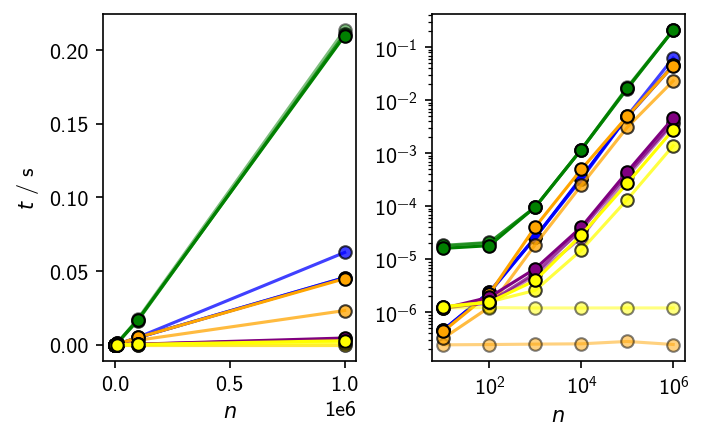

In [45]:
plt.close("all")
fig, ax = plt.subplots(1, 2)
fs = [("set", "blue"),
      ("set_min", "orange"),
      ("array", "green"),
      #("array_min", "red"),
      ("array_custom", "purple"),
      ("array_custom2", "yellow")]
ns = ["10", "100", "1000", "10000", "100000", "1000000"]
ns_ = [int(x) for x in ns]
cs = [("1", 0.5), ("half", 0.75), ("full", 1)]
for f, color in fs:
    for c, alpha in cs:
        timings_ = [x[c].average for x in timings_high_sim[f].values()]
        ax[0].plot(
            ns_, timings_,
            color=color, alpha=alpha,
            marker="o",
            markerfacecolor=color, markeredgecolor="k")
        ax[1].plot(
            ns_, timings_,
            color=color, alpha=alpha,
            marker="o",
            markerfacecolor=color, markeredgecolor="k")
ax[0].set(**{
    "xlabel": "$n$",
    "ylabel": "$t$ / s",
    # "ylim": (-0.01, 0.1),
})
ax[1].set(**{
    "xscale": "log",
    "yscale": "log",
    "xlabel": "$n$",
})
fig.subplots_adjust(wspace=0.3)
# plt.savefig("bm_check_similarity.png")
plt.show()

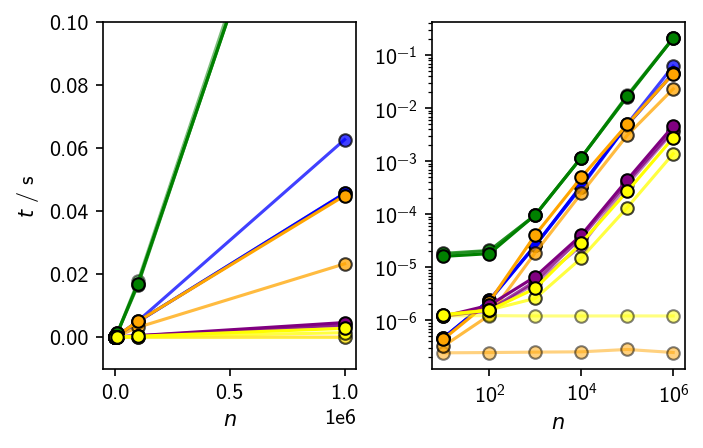

In [51]:
plt.close("all")
fig, ax = plt.subplots(1, 2)
fs = [("set", "blue"),
      ("set_min", "orange"),
      ("array", "green"),
      #("array_min", "red"),
      ("array_custom", "purple"),
      ("array_custom2", "yellow")]
ns = ["10", "100", "1000", "10000", "100000", "1000000"]
ns_ = [int(x) for x in ns]
cs = [("1", 0.5), ("half", 0.75), ("full", 1)]
for f, color in fs:
    for c, alpha in cs:
        timings_ = [x[c].average for x in timings_high_sim[f].values()]
        ax[0].plot(
            ns_, timings_,
            color=color, alpha=alpha,
            marker="o",
            markerfacecolor=color, markeredgecolor="k")
        ax[1].plot(
            ns_, timings_,
            color=color, alpha=alpha,
            marker="o",
            markerfacecolor=color, markeredgecolor="k")
ax[0].set(**{
    "xlabel": "$n$",
    "ylabel": "$t$ / s",
    "ylim": (-0.01, 0.1),
})
ax[1].set(**{
    "xscale": "log",
    "yscale": "log",
    "xlabel": "$n$",
})
fig.subplots_adjust(wspace=0.3)
plt.savefig("bm_check_similarity.png")
plt.show()

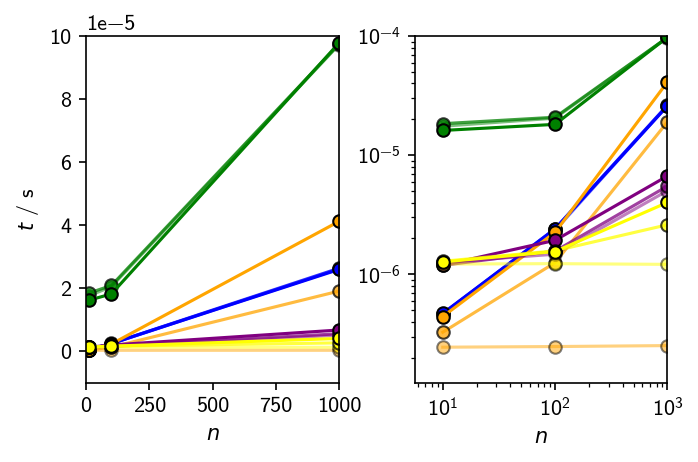

In [50]:
plt.close("all")
fig, ax = plt.subplots(1, 2)
fs = [("set", "blue"),
      ("set_min", "orange"),
      ("array", "green"),
      #("array_min", "red"),
      ("array_custom", "purple"),
      ("array_custom2", "yellow")]
ns = ["10", "100", "1000", "10000", "100000", "1000000"]
ns_ = [int(x) for x in ns]
cs = [("1", 0.5), ("half", 0.75), ("full", 1)]
for f, color in fs:
    for c, alpha in cs:
        timings_ = [x[c].average for x in timings_high_sim[f].values()]
        ax[0].plot(
            ns_, timings_,
            color=color, alpha=alpha,
            marker="o",
            markerfacecolor=color, markeredgecolor="k")
        ax[1].plot(
            ns_, timings_,
            color=color, alpha=alpha,
            marker="o",
            markerfacecolor=color, markeredgecolor="k")
ax[0].set(**{
    "xlabel": "$n$",
    "ylabel": "$t$ / s",
    "ylim": (-0.00001, 0.0001),
    "xlim": (0, 1000),
})
ax[1].set(**{
    "xscale": "log",
    "yscale": "log",
    "xlabel": "$n$",
    "ylim": (None, 0.0001),
    "xlim": (None, 1000),
})
fig.subplots_adjust(wspace=0.3)
# plt.savefig("bm_check_similarity.png")
plt.show()

In [135]:
np.intersect1d(np.arange(10), np.array([1, 1, 1, 1, 1, 1]), assume_unique=False)

array([1])

In [140]:
a = np.array([1, 2, 5, 4, 3, 8])
b = np.array([2, 5, 4, 3, 9])
aux = np.concatenate((a, b))
aux.sort()
mask = aux[1:] == aux[:-1]
int1d = aux[:-1][mask]
int1d

array([2, 3, 4, 5])

In [ ]:
if "timings_low_sim" not in dir():
    timings_low_sim = defaultdict(lambda: defaultdict(dict))
for f, name in [(check_similarity_set, "set"), ]:
    for case in CASES_LOW_SIM:
        case = format_case(case)
        for c in [1, int(case[2]) // 2, int(case[2])]:
            timings_high_sim[name][case[2]][c] = %timeit -o f(*case[:2], c)

In [155]:
from sklearn.neighbors import NearestNeighbors

In [165]:
data = np.random.uniform(size=(20, 5))

In [166]:
data

array([[0.73391482, 0.28696864, 0.48582144, 0.30402796, 0.375301  ],
       [0.38462525, 0.56080514, 0.25542902, 0.90400775, 0.09898257],
       [0.93602879, 0.86826484, 0.80005939, 0.24961222, 0.29558796],
       [0.94819447, 0.68990506, 0.41983289, 0.89793178, 0.05286364],
       [0.5901626 , 0.53803887, 0.46831329, 0.0431153 , 0.66992998],
       [0.7979114 , 0.91434285, 0.57148309, 0.24518511, 0.3809271 ],
       [0.57299437, 0.8315745 , 0.3530245 , 0.48489106, 0.73763019],
       [0.93470662, 0.36502629, 0.5148658 , 0.93696483, 0.54988367],
       [0.73305091, 0.72802003, 0.25137544, 0.36773948, 0.83506226],
       [0.34355281, 0.52208506, 0.41651214, 0.80987567, 0.14107594],
       [0.84429963, 0.24044789, 0.4558434 , 0.3687441 , 0.05108865],
       [0.28120058, 0.10595988, 0.76741607, 0.28137111, 0.31193377],
       [0.69676029, 0.69867432, 0.53818004, 0.74567754, 0.37187044],
       [0.82779472, 0.33118835, 0.57614879, 0.3451896 , 0.51848923],
       [0.5667147 , 0.07554341, 0.

In [167]:
nmodel = NearestNeighbors()
nmodel.fit(data)

NearestNeighbors()

In [171]:
nmodel.radius_neighbors(data, 0.5, return_distance=False)

array([array([ 0,  4, 10, 13]), array([1, 9]), array([2, 5]),
       array([ 3, 12]), array([ 0,  4,  8, 13]), array([2, 5]),
       array([ 6,  8, 16, 19]), array([ 7, 12]), array([ 4,  6,  8, 19]),
       array([ 1,  9, 12]), array([ 0, 10, 13]), array([11]),
       array([ 3,  7,  9, 12]), array([ 0,  4, 10, 13]), array([14]),
       array([15, 16]), array([ 6, 15, 16]), array([17]), array([18]),
       array([ 6,  8, 19])], dtype=object)